In [1]:
import numpy as np
import pandas as pd
import kagglehub
from PIL import Image
import os
from itertools import islice
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torchvision.io import decode_image
from torch.utils.data import Dataset
from Image_Processing import CustomImageDataset, find_jpg_files, generate_dataframe
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from numba import jit, cuda
from timeit import default_timer as timer
from torchvision import transforms

path = kagglehub.dataset_download("fahadullaha/facial-emotion-recognition-dataset")
SEARCH_ROOT_DIR = f"{path}/processed_data/"
fpath = find_jpg_files(SEARCH_ROOT_DIR)
df = generate_dataframe(fpath)

In [2]:
print(torch.cuda.is_available())

True


In [ ]:
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(degrees=15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
# ])

# train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, )
# test_df, ftest_df = train_test_split(test_df, test_size=0.5, random_state=42)
# # Save the split dataframes to CSV files for CustomImageDataset
# train_df.to_csv("train_annotations.csv", index=False)
# test_df.to_csv("test_annotations.csv", index=False)
# ftest_df.to_csv("ftest_annotations.csv", index=False)


# Create Dataset objects using your CustomImageDataset class
train_dataset = CustomImageDataset("train_annotations.csv", SEARCH_ROOT_DIR, transform=transform)
test_dataset = CustomImageDataset("test_annotations.csv", SEARCH_ROOT_DIR)
ftest_dataset = CustomImageDataset("ftest_annotations.csv", SEARCH_ROOT_DIR)

# Create DataLoaders from the Dataset objects
train_loader = torch.utils.data.DataLoader(
    train_dataset,  # Use the Dataset object, not the DataFrame
    batch_size=64,  # number of samples loaded per batch
    shuffle=True,   # randomize the order of samples
    num_workers=2   # number of processes used to load data
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,   # Use the Dataset object, not the DataFrame
    batch_size=64,
    shuffle=False,
    num_workers=2
)
ftest_loader = torch.utils.data.DataLoader(
    ftest_dataset,   # Use the Dataset object, not the DataFrame
    batch_size=64,
    shuffle=False,
    num_workers=2
)

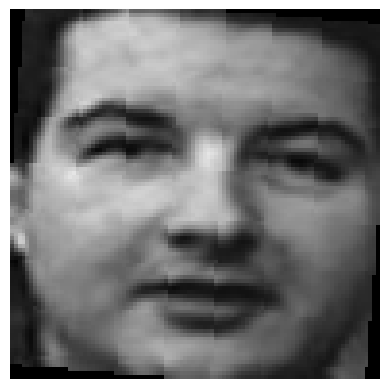

In [6]:
image_tensor = train_dataset[70][0]

# Permute from (C, H, W) to (H, W, C) for matplotlib
image_np = image_tensor.permute(1, 2, 0).numpy()

plt.imshow(image_np)
plt.axis('off')  # Hide axes
plt.show()

In [7]:
import torch.optim as optim
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 8)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) # lr: learning rate affects how quickly the model adjusts parameters
     

In [ ]:
model = models.vgg16(weights=None)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 8)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr: learning rate affects how quickly the model adjusts parameters

Using device: cuda


Epochs: 100%|██████████| 40/40 [47:51<00:00, 71.78s/epoch]

Average training loss: 0.0862
Finished Training


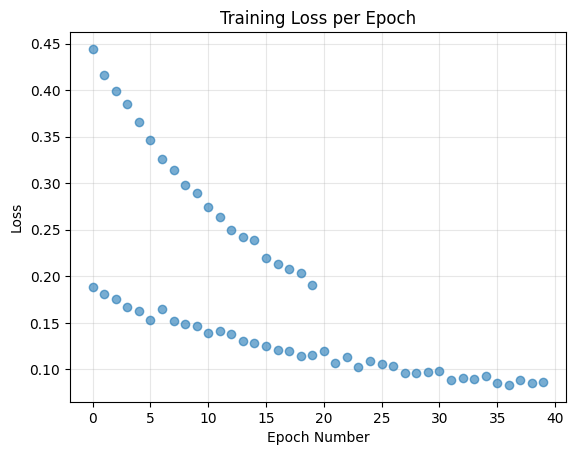

In [18]:
from tqdm import tqdm

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to GPU
model = model.to(device)

# Initialize as empty list (more efficient than np.append in a loop)
#epoch_nums = []
#loss_values = []
#accuracy_values = []

# Wrap the train_loader with tqdm for a progress bar
for epoch in tqdm(range(40), desc="Epochs", unit="epoch"):  # loop over the dataset multiple times

    running_loss = 0.0
    model.train()  # set model to training mode

    for (images, labels) in train_loader: 
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)        # get model predictions for this batch of images
        loss = loss_function(outputs, labels) # calculate loss

        # Track running loss on training data
        running_loss += loss.item()
        
        loss.backward()                       # compute gradients for each weight (how each weight should change to minimize loss)
        optimizer.step()                      # update model weights
        
        optimizer.zero_grad()                 # reset gradients from the previous batch
    correct, total = 0, 0
    i=0
    model.eval()    # set the model to evaluation mode
    with torch.no_grad():  # disable gradient tracking since we're not updating weights
        for images, labels in test_loader:
            # Move data to GPU
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)                 # get model predictions for a batch of images
            _, predicted = torch.max(outputs, 1)           # select the class with the highest score
            total += labels.size(0)                        # count total number of images processed
            correct += (predicted == labels).sum().item() 
            i += 1
            if  i == 2:
                accuracy_values.append(100 * correct / total)
                break  # count how many predictions were correct

        epoch_nums.append(epoch)
        loss_values.append(running_loss/len(train_loader))

print(f"Average training loss: {running_loss / len(train_loader):.4f}")
print("Finished Training")

# Plot the training loss over epochs
plt.plot(epoch_nums, loss_values, 'o', alpha=0.6)
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True, alpha=0.3)
plt.show()

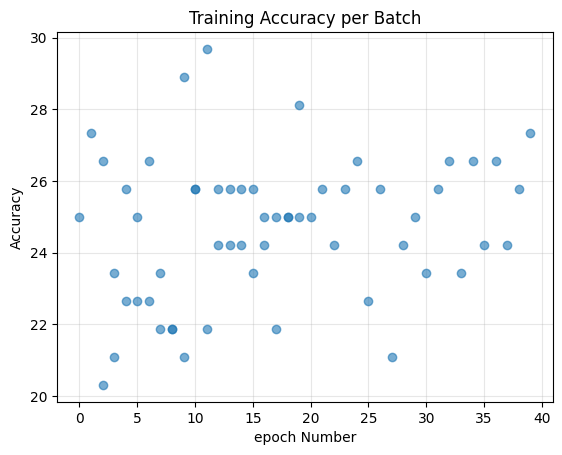

In [19]:
# Plot training loss, skipping the first datapoint
plt.plot(epoch_nums[2:], accuracy_values[2:], 'o', alpha=0.6)
plt.xlabel('epoch Number')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Batch')
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
correct, total = 0, 0
i=0
model.eval()    # set the model to evaluation mode
with torch.no_grad():  # disable gradient tracking since we're not updating weights
    for images, labels in test_loader:
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)                 # get model predictions for a batch of images
        _, predicted = torch.max(outputs, 1)           # select the class with the highest score
        total += labels.size(0)                        # count total number of images processed
        correct += (predicted == labels).sum().item() 
        i += 1
        if  i == 2:
            break  # count how many predictions were correct

print(f"Test accuracy: {100 * correct / total:.2f}%")

Test accuracy: 27.34%


In [13]:
correct, total = 0, 0
i=0
model.eval()    # set the model to evaluation mode
with torch.no_grad():  # disable gradient tracking since we're not updating weights
    for images, labels in train_loader:
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)                 # get model predictions for a batch of images
        _, predicted = torch.max(outputs, 1)           # select the class with the highest score
        total += labels.size(0)                        # count total number of images processed
        correct += (predicted == labels).sum().item()

        i += 1
        if  i == 10:
            break 

print(f"Test accuracy: {100 * correct / total:.2f}%")

Test accuracy: 82.81%


In [20]:

torch.save(model, 'resnetmodelv2.pth') # save model to model.pth file